In [2]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_from_disk
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tabulate import tabulate

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)

split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

test_x = np.array(test_dataset['embedding'])
test_y = np.array(test_dataset['labels'])

from torch.utils.data import Dataset, DataLoader, Subset

class EmbeddingDataset(Dataset):
    def __init__(self, hf_dataset):
        self.embeddings = hf_dataset["embedding"]
        self.labels = hf_dataset["labels"]
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = self.labels[idx]
        return emb, label

train_ds = EmbeddingDataset(train_dataset)
test_ds = EmbeddingDataset(test_dataset)

In [4]:
class DNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(DNNClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        logits = self.fc(x)
        return logits

def train_and_evaluate(model, train_loader, test_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_acc = correct / total
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for embeddings, labels in test_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_loss = test_running_loss / test_total
        test_acc = test_correct / test_total
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    
    return test_acc, all_preds, all_labels

/tmp/ipykernel_49036/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)



使用訓練資料數量: 20 筆
開始訓練...
Epoch 1: Train Loss=0.9928, Train Acc=0.5500 | Test Loss=0.6740, Test Acc=0.7541
Epoch 2: Train Loss=0.6261, Train Acc=0.8000 | Test Loss=0.5023, Test Acc=0.8984
Epoch 3: Train Loss=0.3950, Train Acc=0.9000 | Test Loss=0.4098, Test Acc=0.9029
Epoch 4: Train Loss=0.4137, Train Acc=0.9000 | Test Loss=0.3647, Test Acc=0.8933
Epoch 5: Train Loss=0.3133, Train Acc=0.9000 | Test Loss=0.3529, Test Acc=0.8811
Epoch 6: Train Loss=0.2430, Train Acc=0.9500 | Test Loss=0.3586, Test Acc=0.8679
Epoch 7: Train Loss=0.1717, Train Acc=1.0000 | Test Loss=0.3633, Test Acc=0.8592
Epoch 8: Train Loss=0.1488, Train Acc=0.9500 | Test Loss=0.3751, Test Acc=0.8537
Epoch 9: Train Loss=0.1534, Train Acc=0.9500 | Test Loss=0.3914, Test Acc=0.8481
Epoch 10: Train Loss=0.0757, Train Acc=1.0000 | Test Loss=0.4078, Test Acc=0.8450
Test Accuracy for sample size 20: 0.8450
分類報告:
               precision    recall  f1-score   support

contradiction       0.77      0.91      0.84       271
   enta

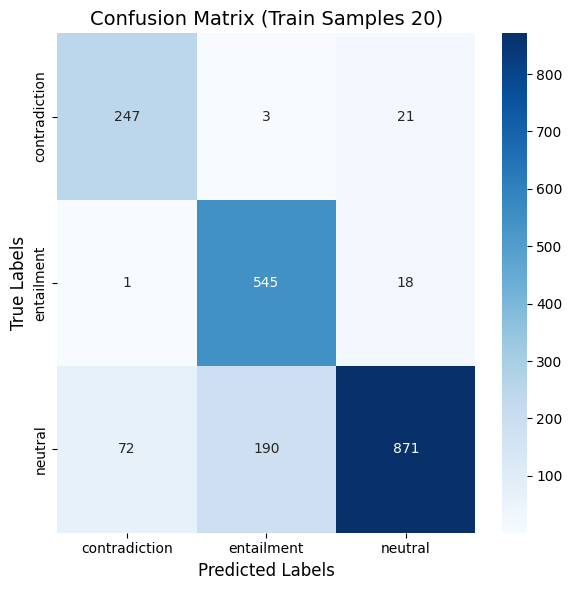


使用訓練資料數量: 50 筆
開始訓練...
Epoch 1: Train Loss=0.9833, Train Acc=0.4400 | Test Loss=0.4876, Test Acc=0.9009
Epoch 2: Train Loss=0.4302, Train Acc=0.9000 | Test Loss=0.3498, Test Acc=0.8877


/tmp/ipykernel_49036/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 3: Train Loss=0.3464, Train Acc=0.8800 | Test Loss=0.3237, Test Acc=0.8811
Epoch 4: Train Loss=0.2574, Train Acc=0.8800 | Test Loss=0.3337, Test Acc=0.8725
Epoch 5: Train Loss=0.2844, Train Acc=0.8800 | Test Loss=0.3388, Test Acc=0.8735
Epoch 6: Train Loss=0.2408, Train Acc=0.8800 | Test Loss=0.3331, Test Acc=0.8796
Epoch 7: Train Loss=0.2007, Train Acc=0.9000 | Test Loss=0.3338, Test Acc=0.8806
Epoch 8: Train Loss=0.1625, Train Acc=0.9400 | Test Loss=0.3407, Test Acc=0.8811
Epoch 9: Train Loss=0.1644, Train Acc=0.9200 | Test Loss=0.3614, Test Acc=0.8780
Epoch 10: Train Loss=0.1429, Train Acc=0.9600 | Test Loss=0.3984, Test Acc=0.8725
Test Accuracy for sample size 50: 0.8725
分類報告:
               precision    recall  f1-score   support

contradiction       0.82      0.87      0.85       271
   entailment       0.79      0.96      0.86       564
      neutral       0.94      0.83      0.88      1133

     accuracy                           0.87      1968
    macro avg       0.85   

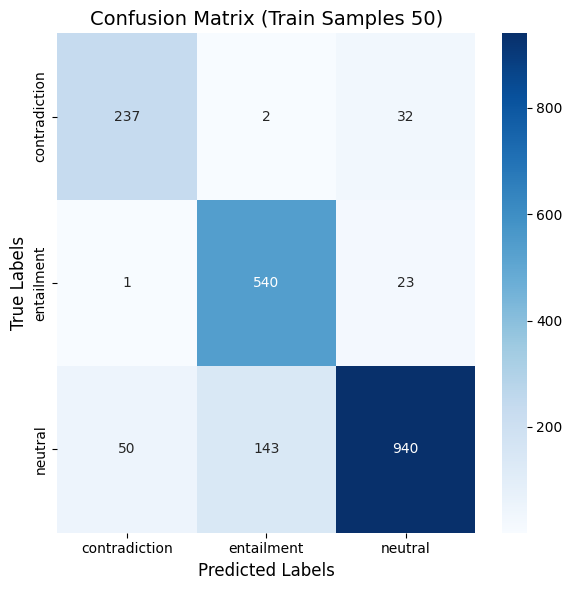


使用訓練資料數量: 70 筆
開始訓練...
Epoch 1: Train Loss=0.9369, Train Acc=0.5571 | Test Loss=0.3944, Test Acc=0.9024
Epoch 2: Train Loss=0.4178, Train Acc=0.8571 | Test Loss=0.2838, Test Acc=0.8974


/tmp/ipykernel_49036/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 3: Train Loss=0.3132, Train Acc=0.8857 | Test Loss=0.3284, Test Acc=0.8714
Epoch 4: Train Loss=0.2732, Train Acc=0.9000 | Test Loss=0.3497, Test Acc=0.8669
Epoch 5: Train Loss=0.2402, Train Acc=0.9000 | Test Loss=0.3342, Test Acc=0.8730
Epoch 6: Train Loss=0.2749, Train Acc=0.9000 | Test Loss=0.2910, Test Acc=0.8892
Epoch 7: Train Loss=0.3217, Train Acc=0.9000 | Test Loss=0.2794, Test Acc=0.8963
Epoch 8: Train Loss=0.2033, Train Acc=0.9429 | Test Loss=0.2803, Test Acc=0.9019
Epoch 9: Train Loss=0.2552, Train Acc=0.9143 | Test Loss=0.2821, Test Acc=0.8963
Epoch 10: Train Loss=0.1981, Train Acc=0.9286 | Test Loss=0.2900, Test Acc=0.8923
Test Accuracy for sample size 70: 0.8923
分類報告:
               precision    recall  f1-score   support

contradiction       0.83      0.87      0.85       271
   entailment       0.86      0.91      0.88       564
      neutral       0.93      0.89      0.91      1133

     accuracy                           0.89      1968
    macro avg       0.87   

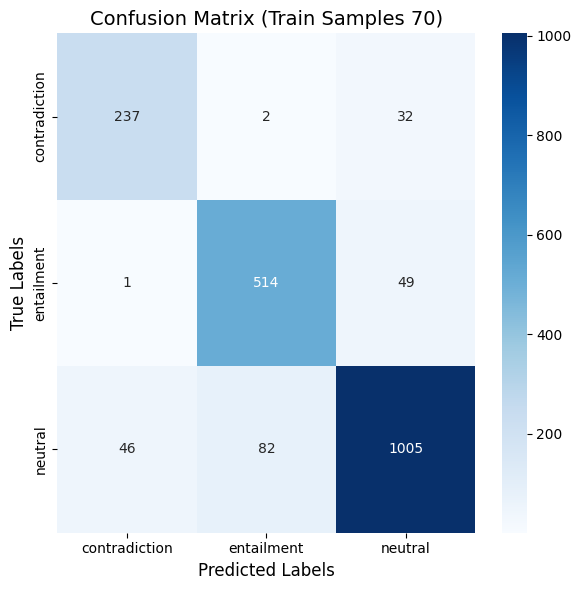


使用訓練資料數量: 100 筆
開始訓練...
Epoch 1: Train Loss=0.8614, Train Acc=0.6500 | Test Loss=0.3348, Test Acc=0.9009
Epoch 2: Train Loss=0.3514, Train Acc=0.8800 | Test Loss=0.2895, Test Acc=0.8958


/tmp/ipykernel_49036/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 3: Train Loss=0.3501, Train Acc=0.8500 | Test Loss=0.2846, Test Acc=0.8928
Epoch 4: Train Loss=0.3105, Train Acc=0.8900 | Test Loss=0.3084, Test Acc=0.8831
Epoch 5: Train Loss=0.2583, Train Acc=0.8800 | Test Loss=0.3347, Test Acc=0.8755
Epoch 6: Train Loss=0.3365, Train Acc=0.9000 | Test Loss=0.3116, Test Acc=0.8831
Epoch 7: Train Loss=0.2502, Train Acc=0.8500 | Test Loss=0.2981, Test Acc=0.8882
Epoch 8: Train Loss=0.2493, Train Acc=0.9100 | Test Loss=0.2814, Test Acc=0.8882
Epoch 9: Train Loss=0.2775, Train Acc=0.9000 | Test Loss=0.2738, Test Acc=0.8948
Epoch 10: Train Loss=0.2645, Train Acc=0.9100 | Test Loss=0.2682, Test Acc=0.8948
Test Accuracy for sample size 100: 0.8948
分類報告:
               precision    recall  f1-score   support

contradiction       0.83      0.88      0.85       271
   entailment       0.88      0.89      0.89       564
      neutral       0.92      0.90      0.91      1133

     accuracy                           0.89      1968
    macro avg       0.88  

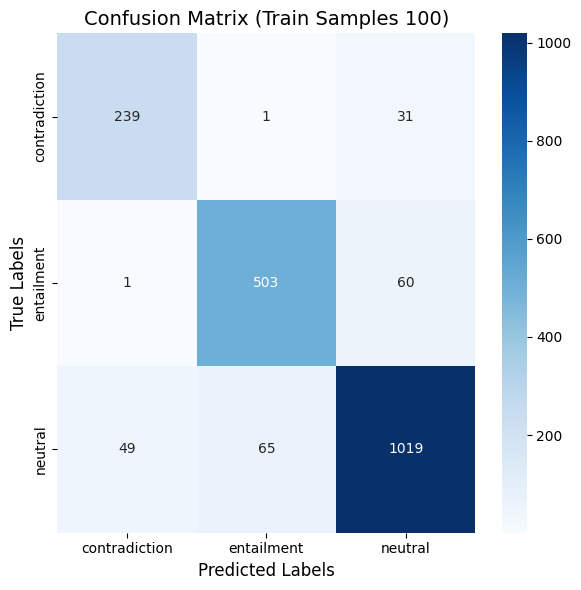


使用訓練資料數量: 300 筆
開始訓練...
Epoch 1: Train Loss=0.4608, Train Acc=0.8633 | Test Loss=0.2986, Test Acc=0.8836
Epoch 2: Train Loss=0.3487, Train Acc=0.8900 | Test Loss=0.2784, Test Acc=0.8974


/tmp/ipykernel_49036/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 3: Train Loss=0.2945, Train Acc=0.9133 | Test Loss=0.2616, Test Acc=0.8968
Epoch 4: Train Loss=0.2742, Train Acc=0.8967 | Test Loss=0.2502, Test Acc=0.9035
Epoch 5: Train Loss=0.2688, Train Acc=0.9067 | Test Loss=0.2597, Test Acc=0.8923
Epoch 6: Train Loss=0.2493, Train Acc=0.9067 | Test Loss=0.2556, Test Acc=0.8989
Epoch 7: Train Loss=0.2444, Train Acc=0.9100 | Test Loss=0.2559, Test Acc=0.9004
Epoch 8: Train Loss=0.2263, Train Acc=0.9100 | Test Loss=0.2526, Test Acc=0.9040
Epoch 9: Train Loss=0.2077, Train Acc=0.9100 | Test Loss=0.2572, Test Acc=0.8989
Epoch 10: Train Loss=0.2141, Train Acc=0.9267 | Test Loss=0.2663, Test Acc=0.8902
Test Accuracy for sample size 300: 0.8902
分類報告:
               precision    recall  f1-score   support

contradiction       0.82      0.87      0.85       271
   entailment       0.92      0.84      0.88       564
      neutral       0.89      0.92      0.91      1133

     accuracy                           0.89      1968
    macro avg       0.88  

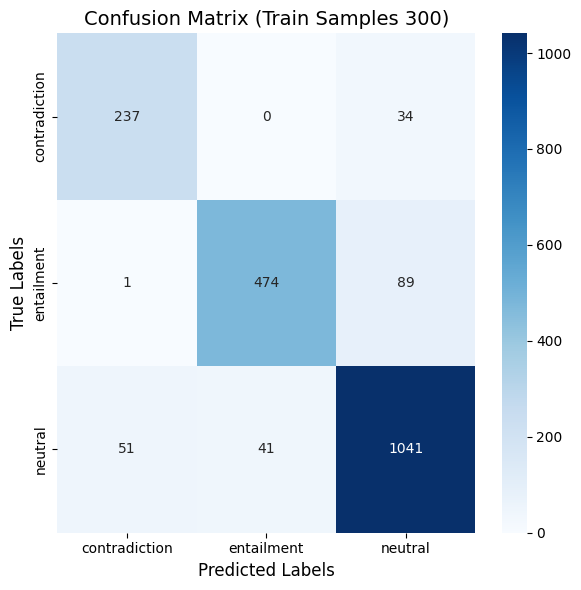


使用訓練資料數量: 1000 筆
開始訓練...
Epoch 1: Train Loss=0.3291, Train Acc=0.8820 | Test Loss=0.2701, Test Acc=0.9004


/tmp/ipykernel_49036/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 2: Train Loss=0.2820, Train Acc=0.9100 | Test Loss=0.2558, Test Acc=0.9014
Epoch 3: Train Loss=0.2690, Train Acc=0.9080 | Test Loss=0.2498, Test Acc=0.9050
Epoch 4: Train Loss=0.2421, Train Acc=0.9160 | Test Loss=0.2657, Test Acc=0.8999
Epoch 5: Train Loss=0.2429, Train Acc=0.9110 | Test Loss=0.2477, Test Acc=0.9085
Epoch 6: Train Loss=0.2252, Train Acc=0.9260 | Test Loss=0.2533, Test Acc=0.9090
Epoch 7: Train Loss=0.2509, Train Acc=0.9090 | Test Loss=0.2452, Test Acc=0.9024
Epoch 8: Train Loss=0.2204, Train Acc=0.9230 | Test Loss=0.2589, Test Acc=0.9080
Epoch 9: Train Loss=0.2261, Train Acc=0.9230 | Test Loss=0.2505, Test Acc=0.9055
Epoch 10: Train Loss=0.2241, Train Acc=0.9180 | Test Loss=0.2517, Test Acc=0.9075
Test Accuracy for sample size 1000: 0.9075
分類報告:
               precision    recall  f1-score   support

contradiction       0.90      0.86      0.88       271
   entailment       0.89      0.90      0.90       564
      neutral       0.92      0.92      0.92      1133


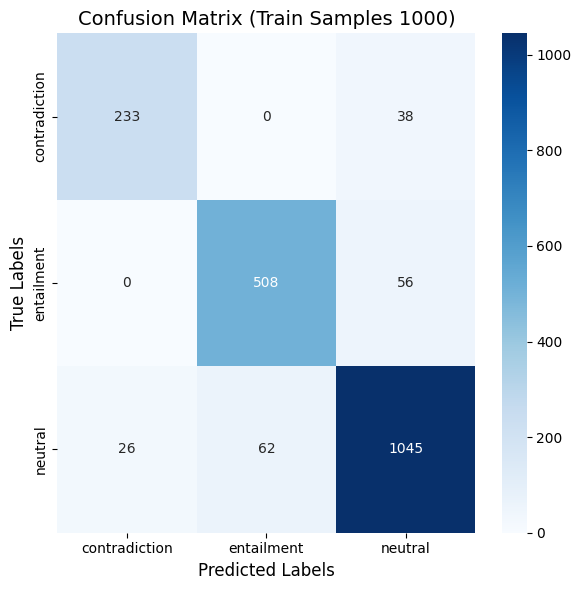


使用訓練資料數量: 7872 筆
開始訓練...


/tmp/ipykernel_49036/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 1: Train Loss=0.2758, Train Acc=0.9049 | Test Loss=0.2420, Test Acc=0.9096
Epoch 2: Train Loss=0.2463, Train Acc=0.9092 | Test Loss=0.2402, Test Acc=0.9060
Epoch 3: Train Loss=0.2364, Train Acc=0.9120 | Test Loss=0.2493, Test Acc=0.9116
Epoch 4: Train Loss=0.2355, Train Acc=0.9131 | Test Loss=0.2354, Test Acc=0.9106
Epoch 5: Train Loss=0.2282, Train Acc=0.9151 | Test Loss=0.2464, Test Acc=0.9111
Epoch 6: Train Loss=0.2361, Train Acc=0.9131 | Test Loss=0.2378, Test Acc=0.9106
Epoch 7: Train Loss=0.2295, Train Acc=0.9160 | Test Loss=0.2357, Test Acc=0.9131
Epoch 8: Train Loss=0.2276, Train Acc=0.9110 | Test Loss=0.2374, Test Acc=0.9111
Epoch 9: Train Loss=0.2285, Train Acc=0.9182 | Test Loss=0.2402, Test Acc=0.9111
Epoch 10: Train Loss=0.2228, Train Acc=0.9155 | Test Loss=0.2416, Test Acc=0.9136
Test Accuracy for sample size 7872: 0.9136
分類報告:
               precision    recall  f1-score   support

contradiction       0.94      0.85      0.89       271
   entailment       0.93     

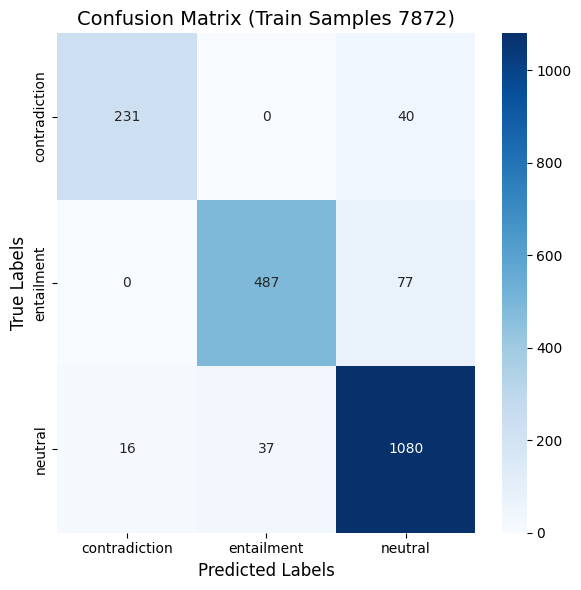

In [12]:
sample_sizes = [20, 50, 70, 100, 300, 1000, len(train_ds)]
num_epochs = 10
learning_rate = 0.001
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_emb, _ = train_ds[0]
input_dim = sample_emb.shape[0]
hidden_dim = 128
num_classes = 3  

accuracy_list = {}

for size in sample_sizes:
    print(f"\n使用訓練資料數量: {size} 筆")
    # 從 train_ds 中取前 size 筆作為訓練子集
    train_subset = Subset(train_ds, range(size))
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    # 初始化 DNN 模型
    model = DNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    model.to(device)
    
    print("開始訓練...")
    test_acc, all_preds, all_labels = train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate, device)
    print(f"Test Accuracy for sample size {size}: {test_acc:.4f}")
    
    print("分類報告:")
    print(classification_report(all_labels, all_preds, target_names=["contradiction", "entailment", "neutral"]))
    
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues,
                xticklabels=["contradiction", "entailment", "neutral"],
                yticklabels=["contradiction", "entailment", "neutral"])
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.title(f"Confusion Matrix (Train Samples {size})", fontsize=14)
    plt.tight_layout()
    plt.show()
    accuracy_list.update({size: test_acc})

In [13]:
print(tabulate([[size, arr] for size, arr in accuracy_list.items()], headers=["Train Size", "Accuracy"], tablefmt="fancy_grid"))

╒══════════════╤════════════╕
│   Train Size │   Accuracy │
╞══════════════╪════════════╡
│           20 │   0.84502  │
├──────────────┼────────────┤
│           50 │   0.872459 │
├──────────────┼────────────┤
│           70 │   0.892276 │
├──────────────┼────────────┤
│          100 │   0.894817 │
├──────────────┼────────────┤
│          300 │   0.890244 │
├──────────────┼────────────┤
│         1000 │   0.90752  │
├──────────────┼────────────┤
│         7872 │   0.913618 │
╘══════════════╧════════════╛
